In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
import scipy
import poppy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx
from model_kit import magaoxFunctions as mf

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def rms(data):
    return np.sqrt(np.sum(np.square(data))/len(data))

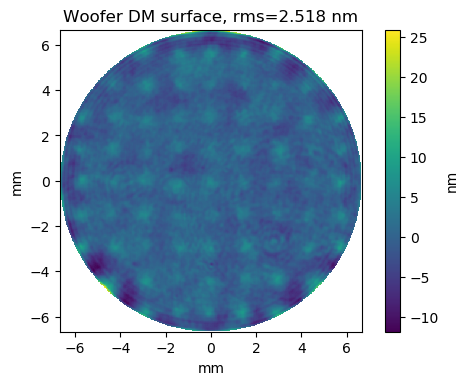

In [2]:
dm_raw = fits.open('woofer_flat.fits')[0].data * u.micron
dm_raw = dm_raw.to(u.nm)
dm_pixscl = (0.0261627907 * u.mm).to(u.m)/u.pix

# resize the matrix. Zygo does weird things with size of data.
# numbers and sides determined from probing, already deleted.
dm = dm_raw[2:dm_raw.shape[0]-3, 1:dm_raw.shape[1]]

# make a mask
cen = int(dm.shape[0]/2)
yy, xx = np.mgrid[-cen:cen+1, -cen:cen+1]
mask = (yy**2 + xx**2 <= cen**2)

# aply mask to wfdm
dm = dm*mask

# calculate rms
dm_rms = rms(dm[mask==1])

# show surface
dfx.show_image(data=dfx.sn_map(dm.value, mask),
               data_unit=dm.unit,
               pixscale=(dm_pixscl*u.pix).to(u.mm),
               fig_title='Woofer DM surface, rms={0:.3f}'.format(dm_rms))

### Interpolate the data with griddata

In [3]:
dm.shape

(511, 511)

CPU times: user 1.72 s, sys: 19.4 ms, total: 1.74 s
Wall time: 1.37 s


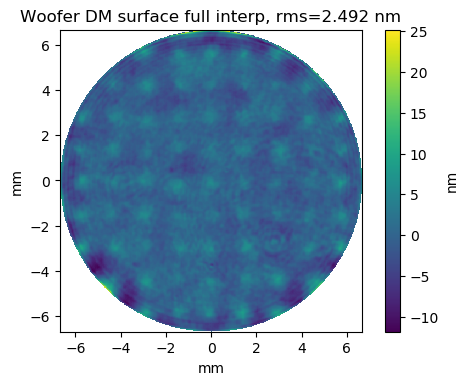

In [4]:
%%time
# build the coordinate points for the original data
d_dm = dm.shape[0]*dm_pixscl
r_dm = d_dm/2
oy, ox = np.mgrid[-r_dm.value:r_dm.value:511j,
                  -r_dm.value:r_dm.value:511j]
orig_y = np.reshape(np.flipud(oy), np.product(oy.shape))
orig_x = np.reshape(ox, np.product(ox.shape))
    
# build the grids for the poppy scale
pixscl = 2.432331649e-05*u.m # pre-calculated from poppy
zoom_scl = (dm_pixscl.value/pixscl.value)
new_npix = np.ceil(zoom_scl*dm.shape[0]).astype(int)
npix_half = int(new_npix/2)
ny, nx = np.mgrid[-npix_half:npix_half,
                  -npix_half:npix_half]
new_y = np.flipud(ny)*pixscl
new_x = nx*pixscl

# interpolate the data
lin_dm = np.reshape(dm.value, np.product(dm.shape))
interp_dm = scipy.interpolate.griddata((orig_y,orig_x), lin_dm, (new_y, new_x),
                                         method='nearest', fill_value=0.0)

# calculate rms
interp_cen = int(interp_dm.shape[0]/2)
iy, ix = np.mgrid[-interp_cen:interp_cen, -interp_cen:interp_cen]
interp_mask = (iy**2 + ix**2 <= interp_cen**2)
dm_rms_interp = rms(interp_dm[interp_mask==1])*dm.unit

# show surface
dfx.show_image(data=dfx.sn_map(interp_dm, interp_mask),
               data_unit=dm.unit,
               pixscale=(pixscl).to(u.mm),
               fig_title='Woofer DM surface full interp, rms={0:.3f}'.format(dm_rms_interp))

In [5]:
np.amax(dm.value*mask)

25.88184316608721

In [6]:
np.amax(interp_dm*interp_mask)

25.15198420170823

In [7]:
np.amin(dm.value*mask)

-11.813026740380648

In [8]:
np.amin(interp_dm*interp_mask)

-11.813026740380648

### Crop and save data

In [9]:
samp = 538 # new sample size
crop_dm = poppy.utils.pad_or_crop_to_shape(interp_dm, (samp, samp))

# save the opd with angle and without the pupil mask
refl_ang = 15*u.deg
opd = (crop_dm * 2 * dm.unit / np.cos(refl_ang)).to(u.m)
hdr = fits.Header()
hdr['puplscal'] = (pixscl.value, 'pixel scale [m/pix]')
hdr['bunit'] = (str(opd.unit), 'OPD units')
hdr['refl_ang'] = (refl_ang.value, 'reflection angle [deg]')
fits.writeto('woofer_meters_opd_{0}.fits'.format(samp),
             opd.value, hdr, overwrite=True)

### RMS checking with other masks

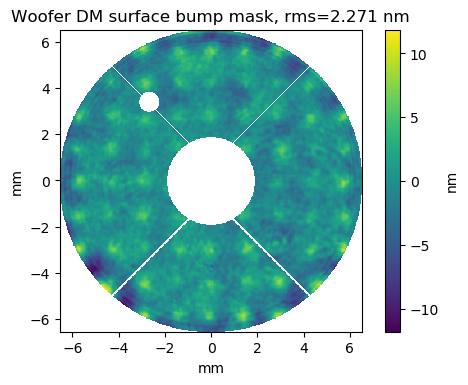

In [15]:
# check rms and wavefront with pupil bump mask
bump_pupil = mf.mag_pupil_mask(samp=samp, entrance_radius=3.25*u.m,
                               wavelength=632*u.nm, bump=True)
# woofer is same orientation as pupil, no need for rotation

bump_rms = rms(crop_dm[bump_pupil==1])*dm.unit
# show surface
dfx.show_image(data=dfx.sn_map(crop_dm, bump_pupil),
               data_unit=dm.unit,
               pixscale=(pixscl).to(u.mm),
               fig_title='Woofer DM surface bump mask, rms={0:.3f}'.format(bump_rms))

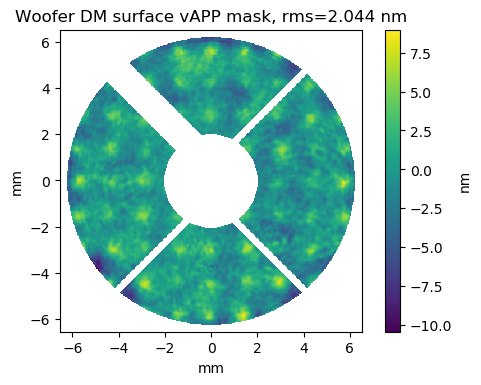

In [16]:
home_dir = '/home/jhen/XWCL/code/MagAOX/' # change for exao0
vapp_dir = home_dir + 'data/coronagraph/'
vapp_filename = 'vAPP_trans_2PSF_538_4x_656nm.fits'
vapp_mask = fits.open(vapp_dir+vapp_filename)[0].data

vapp_rms = rms(crop_dm[vapp_mask==1])*dm.unit
# show surface
dfx.show_image(data=dfx.sn_map(crop_dm, vapp_mask),
               data_unit=dm.unit,
               pixscale=(pixscl).to(u.mm),
               fig_title='Woofer DM surface vAPP mask, rms={0:.3f}'.format(vapp_rms))

In [17]:
# check rms with angle component
vapp_rms/np.cos(refl_ang)

<Quantity 2.11559089 nm>